[View in Colaboratory](https://colab.research.google.com/github/betogaona7/Creative-tensorflow/blob/master/CIFAR_10_Classifier.ipynb)

In [0]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import tensorflow as tf

In [0]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


In [0]:
!pip install -q tqdm

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [15]:
from google.colab import files
files.os.listdir()

['datalab',
 '.config',
 '.local',
 '.keras',
 '.ipython',
 'cifar-10-python.tar.gz',
 '.cache',
 'cifar-10-batches-py',
 '.nv',
 '.forever']

# **Auxiliar functions**

In [0]:

def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_cfar10_batch(cifar10_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
    
    return features, labels

def display_stats(cifar10_folder_path, batch_id, sample_id):
    """
    Display stats of the dataset
    """
    batchs_ids = list(range(1,6))
    if batch_id not in batchs_ids:
        print('Batch id out of range (1 to 5 only)')
        return None
    
    features, labels = load_cfar10_batch(cifar10_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('Sample id out of range (there are only {} saimples in batch {})'.format(len(features), batch_id))
        return None
    
    print('\nStats of batch: {}'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 labels: {}'.format(labels[:20]))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names =_load_label_names()
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.axis('off')
    plt.imshow(sample_image)
    
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the test data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all test data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')

# **Explore the data**


Stats of batch: 5
Samples: 10000
Label counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 1000:
Image - Min Value: 28 Max Value: 228
Image - Shape: (32, 32, 3)
Label - Label Id: 7 Name: horse


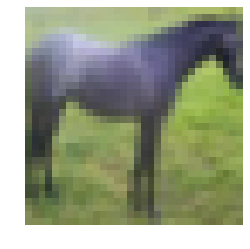

In [16]:
%matplotlib inline 
%config InLineBackend.figure_format = 'retina'

cifar10_folder_path = 'cifar-10-batches-py'
batch_id = 5
sample_id = 1000

display_stats(cifar10_folder_path, batch_id, sample_id)

# **Implement preprocessing functions**

In [0]:
def normalize(x):
    """ 
    Normalize a list of sample image data in the range of 0 to 1.
        x : List of image data. Image shape is (32, 32, 3)
        return: Numpy array of normalized data
    """
    return np.array((x)/255)

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
        x : List of sample labels
        return: Numpy array of one-hot encoded labels
    """
    lb = preprocessing.LabelBinarizer()
    lb.fit(x)
    lb.classes_ = [0,1,2,3,4,5,6,7,8,9]
    return lb.transform(x)

preprocess_and_save_data(cifar10_folder_path, normalize, one_hot_encode)

# **Check point**

In [0]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

# **Build the network**

In [0]:
# Input
def nn_image_input(image_shape):
    return tf.placeholder(tf.float32, shape=[None, image_shape[0], image_shape[1], image_shape[2]], name='x')

def nn_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=[None, n_classes], name='y')

def nn_keep_prob_input():
    return tf.placeholder(tf.float32, name='keep_prob')

# Convolution and Max pooling 
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    weights = tf.Variable(tf.truncated_normal([conv_ksize[0], conv_ksize[1], int(x_tensor.shape[3]), conv_num_outputs]))
    bias = tf.Variable(tf.zeros([conv_num_outputs]))
    # Apply convolution
    x_tensor = tf.nn.conv2d(x_tensor, weights, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    # Add bias 
    x_tensor = tf.nn.bias_add(x_tensor, bias)
    # Add non-linear function
    x_tensor = tf.nn.relu(x_tensor)
    # Apply max pooling
    x_tensor = tf.nn.max_pool(x_tensor, ksize=[1, pool_ksize[0], pool_ksize[1], 1], strides=[1, pool_strides[0],
                              pool_strides[1],1], padding='SAME')
    return x_tensor

# Flatten 
def flatten(x_tensor):
    image_dimensions = x_tensor.get_shape().as_list()
    image_flat_size = image_dimensions[1] * image_dimensions[2] * image_dimensions[3]
    return tf.reshape(x_tensor, [-1, image_flat_size])

# Fully connected layer 
def fully_conn(x_tensor, num_outputs):
    weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), num_outputs], mean=0., stddev=0.1))
    bias = tf.Variable(tf.zeros([num_outputs]))
    # Apply a fully connected layer
    x_tensor = tf.add(tf.matmul(x_tensor, weights), bias)
    # Add non-linear function
    x_tensor = tf.nn.relu(x_tensor)
    return x_tensor

# Output layer 
def output (x_tensor, num_outputs):
    weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), num_outputs], mean=0., stddev=0.1))
    bias = tf.Variable(tf.zeros([num_outputs]))
    # Output layer
    x_tensor = tf.add(tf.matmul(x_tensor, weights), bias)
    return x_tensor

In [0]:
def conv_net(x, keep_prob):
    conv_ksize = (4, 4)
    conv_strides = (2, 2)
    pool_ksize = (4,4)
    pool_strides = (2, 2)
    
    #conv1 = conv2d_maxpool(x, 16, conv_ksize, conv_strides, pool_ksize, pool_strides)
    #conv2 = conv2d_maxpool(conv1, 8, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv2 = conv2d_maxpool(x, 16, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    fc1 = flatten(conv2)
    fc1 = fully_conn(fc1, 256)
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    #fc2 = fully_conn(fc1, 256)
    #fc2 = tf.nn.dropout(fc2, keep_prob)
    
    out = output(fc1, 10)
    return out
    

# Train neural network

In [0]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [46]:
def train_neural_network(session, optimizer, keep_proba, feature_batch, label_batch):
    return session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, keep_prob:keep_proba})

def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = session.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.})
    valid_acc = sess.run(accuracy, feed_dict={x:valid_features, y:valid_labels, keep_prob:1.})
    print("Loss: {:>10.4f} Validation accuracy: {:.6f}".format(loss, valid_acc))
    return None

epochs = 100
batch_size = 100
keep_proba = 0.5

tf.reset_default_graph()

x = nn_image_input((32, 32, 3))
y = nn_label_input(10)
keep_prob = nn_keep_prob_input()

logits = conv_net(x, keep_prob)
logits = tf.identity(logits, name='logits')
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

print("Checking the training on a single batch")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_proba, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}: '.format(epoch+1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the training on a single batch
Epoch  1, CIFAR-10 Batch 1: Loss:     2.1016 Validation accuracy: 0.264800
Epoch  2, CIFAR-10 Batch 1: Loss:     1.9780 Validation accuracy: 0.335800
Epoch  3, CIFAR-10 Batch 1: Loss:     1.9782 Validation accuracy: 0.384200
Epoch  4, CIFAR-10 Batch 1: Loss:     1.9111 Validation accuracy: 0.387600
Epoch  5, CIFAR-10 Batch 1: Loss:     1.8275 Validation accuracy: 0.414200
Epoch  6, CIFAR-10 Batch 1: Loss:     1.7854 Validation accuracy: 0.429600
Epoch  7, CIFAR-10 Batch 1: Loss:     1.7298 Validation accuracy: 0.447600
Epoch  8, CIFAR-10 Batch 1: Loss:     1.6650 Validation accuracy: 0.451200
Epoch  9, CIFAR-10 Batch 1: Loss:     1.6697 Validation accuracy: 0.467400
Epoch 10, CIFAR-10 Batch 1: Loss:     1.6060 Validation accuracy: 0.467200
Epoch 11, CIFAR-10 Batch 1: Loss:     1.5784 Validation accuracy: 0.471000
Epoch 12, CIFAR-10 Batch 1: Loss:     1.5246 Validation accuracy: 0.479000
Epoch 13, CIFAR-10 Batch 1: Loss:     1.4941 Validation accu